In [1]:
from math import ceil

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_data_validation as tfdv
from sklearn.model_selection import train_test_split

2022-09-24 18:21:18.357886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Exploration and Stats

In [19]:
df = pd.read_csv('coding_round_data.csv')
print(df.head(2))

   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                      0.0   
1                     0.0               2                     64.0   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0          0.2        0.2         0.0         0.0   Feb                 1   
1          0.0        0.1         0.0         0.0   Feb                 2   

   Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
0        1       1            1  Returning_Visitor    False    False  
1        2       1            2  Returning_Visitor    False    False  


In [3]:
# shows that no null values exist
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
# check for imbalanced dataset
rev_true = df[df["Revenue"]==True]
print(f'Number of records where customer bought a product: {len(rev_true)}')
print(f'Total number of records: {len(df)}')

Number of records where customer bought a product: 1908
Total number of records: 12330


### Correlation between each feature and target variable

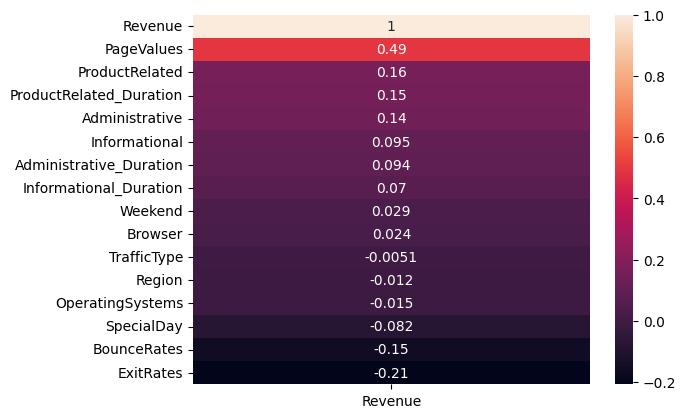

In [5]:
corr_matrix = df.corr()
# correlation between each feature and target variable
corr_df = pd.DataFrame(corr_matrix["Revenue"].sort_values(ascending=False))

# correlation using heatmap
ax = sns.heatmap(corr_df, annot=True)

### Plot Distributions

In [6]:
plt.rcParams['figure.figsize'] = [10,10]

In [7]:
continuous_var = ["Administrative", "Administrative_Duration", "Informational", "Informational_Duration", 
"ProductRelated", "ProductRelated_Duration", "BounceRates", "ExitRates", "PageValues", "SpecialDay"]

# special day has limited values so also include here
categorical_var = ['SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
'Weekend', 'Revenue']

In [8]:
""" Inputs:
        df: dataframe
        x: list of feature names, continuous variables
    Output:
        Plots each x, to see distribution
"""
def plot_dist(df, features):

    plt.figure()
    n = len(features)
    for f, i in zip(features, range(1, n+1)):
        x = df[f]
        plt.subplot(ceil(n/2), 2, i)
        plt.plot(x)
        plt.xlabel(f)
    plt.subplots_adjust(hspace=1.2, wspace=0.5)


"""Inputs:
        df: dataframe
        features: list of column names, categorical variables
    Outputs:
        plots the count of distinct values of each column
"""
def plot_count(df, features):
    plt.figure()
    n = len(features)
    for f, i in zip(features, range(1, n+1)):
        plt.subplot(ceil(n/2), 2, i)
        df[f].value_counts().plot(kind='bar', title=f, rot=0)

    plt.subplots_adjust(hspace=1.2, wspace=0.5)
        

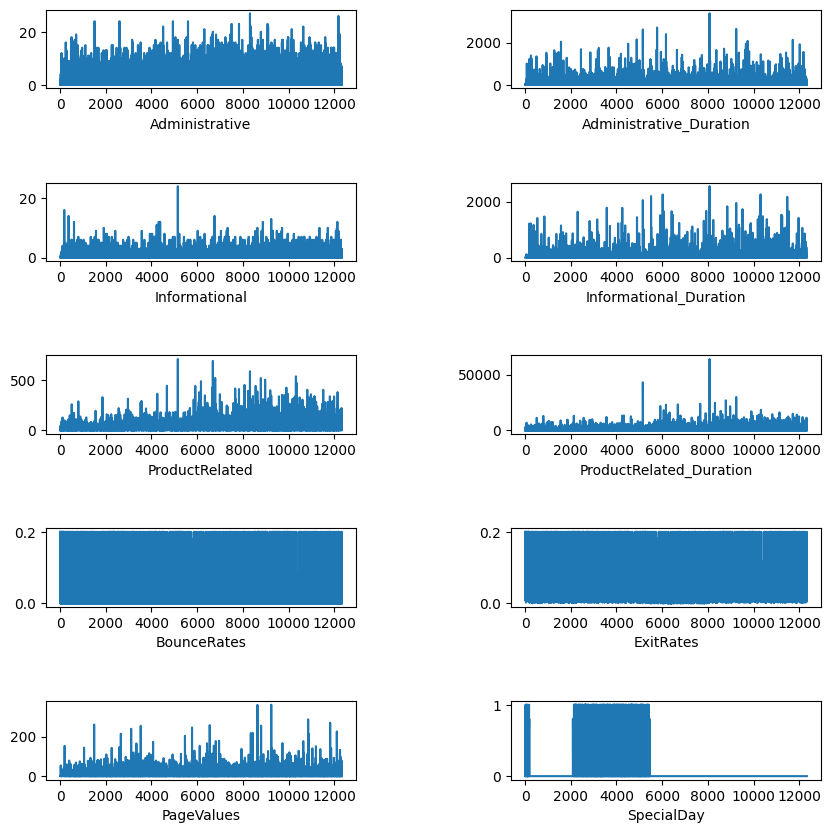

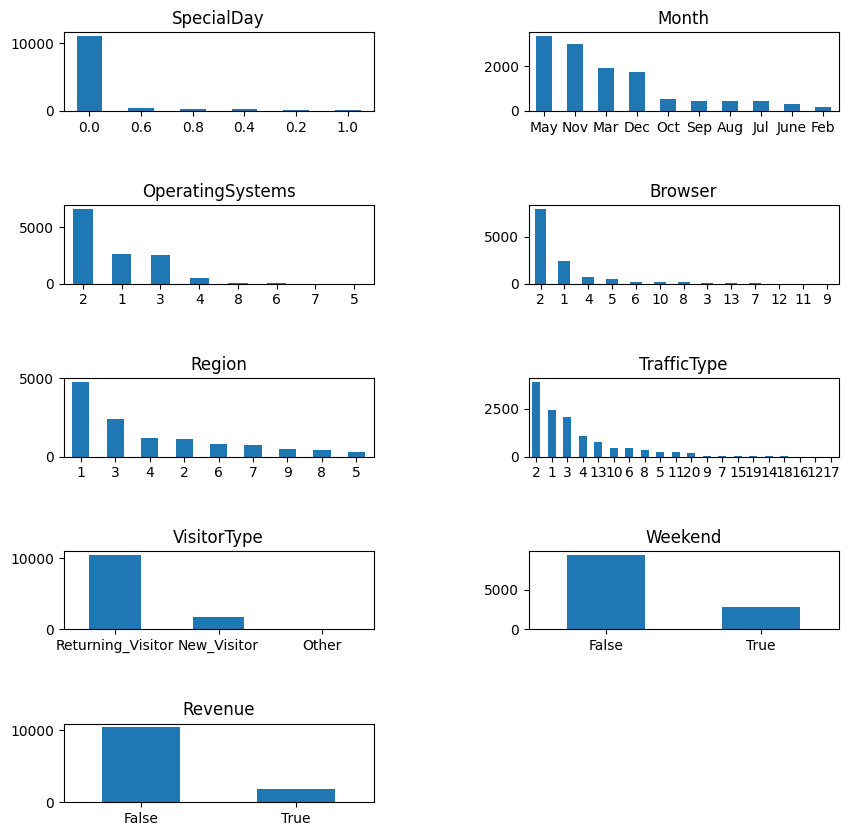

In [9]:
plot_dist(df, continuous_var)
plot_count(df, categorical_var)

### Tensorflow Extended:
- StatisticsGen component to generate statistics, schema and overall visualizations
- fix any anomalies

NOTE: tfdv treats integers as numerical features (revenue, weekend etc., as numerical) but still useful for displaying stats, validating evaluation dataset and inferring general schema

In [11]:
# split into train and test, random_state for reproducability
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0, stratify=df["Revenue"])

train_stats = tfdv.generate_statistics_from_dataframe(train_df)
tfdv.visualize_statistics(train_stats)

In [12]:
# Infer schema from the statistics.
schema = tfdv.infer_schema(statistics=train_stats)

# Display schema
tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'Administrative',INT,required,,-
'Administrative_Duration',FLOAT,required,,-
'Informational',INT,required,,-
'Informational_Duration',FLOAT,required,,-
'ProductRelated',INT,required,,-
'ProductRelated_Duration',FLOAT,required,,-
'BounceRates',FLOAT,required,,-
'ExitRates',FLOAT,required,,-
'PageValues',FLOAT,required,,-


,Values
Domain,
'Month',"'Aug', 'Dec', 'Feb', 'Jul', 'June', 'Mar', 'May', 'Nov', 'Oct', 'Sep'"
'VisitorType',"'New_Visitor', 'Other', 'Returning_Visitor'"


In [13]:
# Generate eval dataset statistics
eval_stats = tfdv.generate_statistics_from_dataframe(test_df)

# Compare with training
tfdv.visualize_statistics(
    lhs_statistics=eval_stats, 
    rhs_statistics=train_stats, 
    lhs_name='EVAL_DATASET', 
    rhs_name='TRAIN_DATASET'
)

In [14]:
# Check evaluation data for errors by validating the eval dataset using the original schema
anomalies =  tfdv.validate_statistics(statistics=eval_stats, schema=schema)

# Visualize anomalies
tfdv.display_anomalies(anomalies)

# Data Preprocessing

## Convert Categorical columns to numerical
Using one-hot encoding for high cardinality categorical attributes (like region, month etc.,) will increase the features significantly and skew the tree, so although these categories are not ordinal, use Label-encoding for these and based on the feature importance we can modify.
Use one hot encoding for others.

In [20]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [21]:
df = pd.read_csv('coding_round_data.csv')

# 'OperatingSystems', 'Browser', 'Region', 'TrafficType' are already label encoded 
# 'Weekend', 'Revenue' are also encoded properly
label_encode = ['Month', 'VisitorType']
#one_hot = ['VisitorType']

le = LabelEncoder()
df[label_encode] = df[label_encode].apply(lambda col: le.fit_transform(col))

#df = pd.get_dummies(df, columns = one_hot)

df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  int64  
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,2,1,1,1,1,2,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,2,2,2,1,2,2,False,False


## XGBoost - Feature importance, selection, model training
- feature importance using xgboost (with handling imbalanced dataset) and selection using importance thresholds
- Use general best practice hyper-parameters for selection. Train and tune model after selecting important features
- train xgboost model with selected features and hyper-parameter tuning

In [44]:
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

In [46]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0, stratify=df["Revenue"])

X_train = train_df.drop(columns=["Revenue"])
Y_train = train_df["Revenue"]
X_test = test_df.drop(columns=["Revenue"])
Y_test = test_df["Revenue"]

print(len(X_train.columns))
print(len(X_test.columns))
print(Y_train.name)
print(Y_test.name)

17
17
Revenue
Revenue


## Feature Importance

In [47]:
# for imbalanced data
# xgboost 1 is positive class = minority class
# total number of examples in the majority class divided 
# by the total number of examples in the minority class.

maj_n = len(train_df[train_df["Revenue"]==0]) # majority samples
min_n = len(train_df[train_df["Revenue"]==1]) # minority (where revenue is True)
scale_pos_weight = maj_n/min_n # scales the gradient for minority class

model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5, scale_pos_weight=scale_pos_weight)
model.fit(X_train, Y_train)

#save model
model.save_model('models/feature_importance.txt')

[('PageValues', 0.45677063), ('Month', 0.12570454), ('VisitorType', 0.04447662), ('BounceRates', 0.03745079), ('ProductRelated_Duration', 0.032002274), ('ProductRelated', 0.030302105), ('Administrative_Duration', 0.029654052), ('Informational', 0.028460277), ('Administrative', 0.028084211), ('ExitRates', 0.027467547), ('SpecialDay', 0.025850315), ('Weekend', 0.025361724), ('TrafficType', 0.024541002), ('Region', 0.023580482), ('Informational_Duration', 0.022883398), ('Browser', 0.019774392), ('OperatingSystems', 0.017635684)]


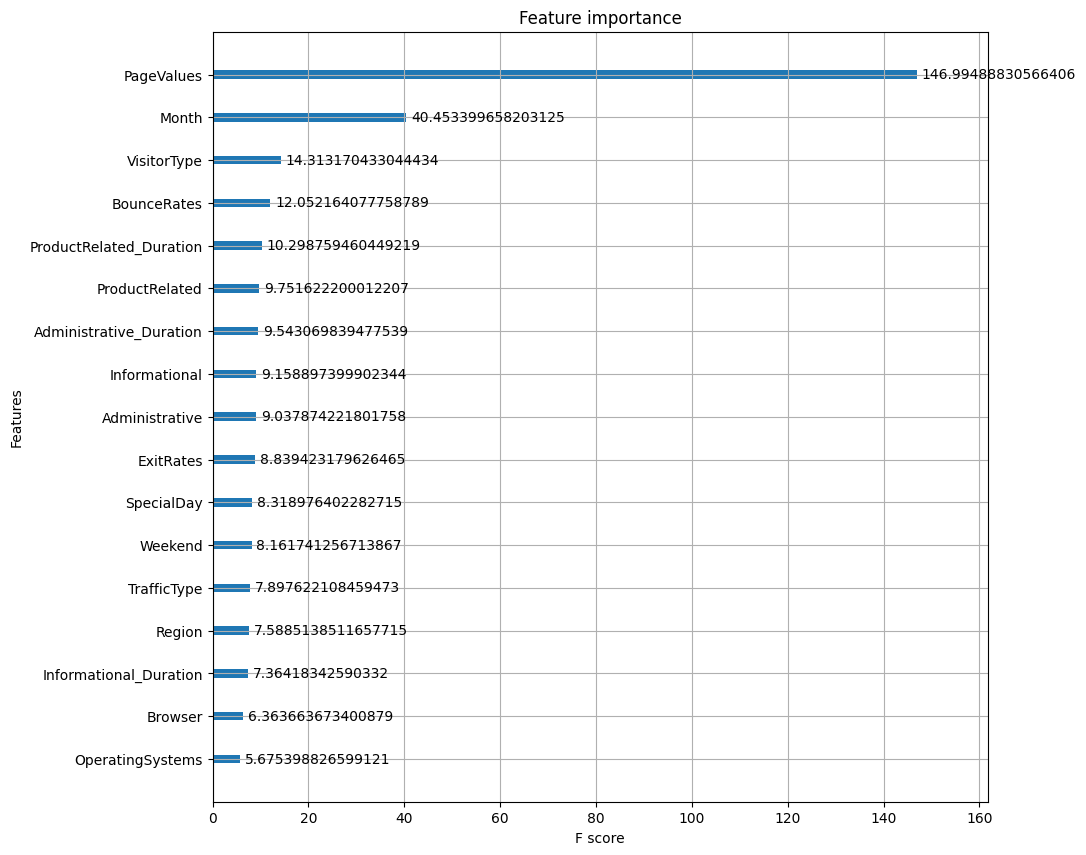

In [55]:
f_imp = zip(model.get_booster().feature_names, model.feature_importances_) # uses gain as importance type
f_imp = sorted(f_imp, key=lambda x: x[1], reverse=True)
print(f_imp)

# show feature importances
plot_importance(model, importance_type='gain')
plt.show()


## Feature Selection

In [64]:
# feature selection
""" Inputs:
        thresh: a threshold value for feature importance, any features with imp >= thresh get selected.
                trains and tests model for the subset of features selected
    Outputs:
        prints the threshold and the accuracy
        returns the names of the selected features and the model trained on that subset
"""
def model_select(thresh):
    # select features using threshold, any feature with imp > threshold gets selected
    selected_features = [x[0] for x in f_imp if x[1] >= thresh]
    select_X_train = X_train[selected_features] 

    # train the model with feature subset
    select_model = XGBClassifier()
    select_model.fit(select_X_train, Y_train)

    # eval model, get predictions, convert to 0 or 1
    select_X_test = X_test[selected_features]
    y_pred = select_model.predict(select_X_test)

    pred = [round(value) for value in y_pred]
    accuracy = accuracy_score(Y_test, pred)

    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

    return selected_features, select_X_train, select_X_test, select_model


thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    model_select(thresh)

Thresh=0.018, n=17, Accuracy: 89.42%
Thresh=0.020, n=16, Accuracy: 89.17%
Thresh=0.023, n=15, Accuracy: 89.42%
Thresh=0.024, n=14, Accuracy: 89.05%
Thresh=0.025, n=13, Accuracy: 89.29%
Thresh=0.025, n=12, Accuracy: 89.01%
Thresh=0.026, n=11, Accuracy: 89.46%
Thresh=0.027, n=10, Accuracy: 89.17%
Thresh=0.028, n=9, Accuracy: 88.85%
Thresh=0.028, n=8, Accuracy: 89.01%
Thresh=0.030, n=7, Accuracy: 89.33%
Thresh=0.030, n=6, Accuracy: 89.21%
Thresh=0.032, n=5, Accuracy: 89.21%
Thresh=0.037, n=4, Accuracy: 88.77%
Thresh=0.044, n=3, Accuracy: 88.04%
Thresh=0.126, n=2, Accuracy: 87.83%
Thresh=0.457, n=1, Accuracy: 87.67%


In [67]:
# model with best accuracy - accuracy 89.46, n = 11
thresh = thresholds[6]
selected_features, select_X_train, select_X_test, selected_model = model_select(thresh)
print(selected_features)

selected_model.save_model('models/feature_selection_model.txt')

Thresh=0.026, n=11, Accuracy: 89.46%
['PageValues', 'Month', 'VisitorType', 'BounceRates', 'ProductRelated_Duration', 'ProductRelated', 'Administrative_Duration', 'Informational', 'Administrative', 'ExitRates', 'SpecialDay']


## Model finetuning and metrics

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [93]:
LR = 0.04
n_est = 300
max_depth = 7

eval_metric = ["logloss", "auc"]
esr = 150 # early stopping to avoid overfitting

eval_set = [(select_X_train, Y_train), (select_X_test, Y_test)]

model = XGBClassifier(learning_rate=LR, n_estimators=n_est, max_depth=max_depth, scale_pos_weight=scale_pos_weight)
model.fit(select_X_train, Y_train, eval_metric=eval_metric, eval_set=eval_set, early_stopping_rounds=esr, verbose=True)

[0]	validation_0-logloss:0.66812	validation_0-auc:0.94707	validation_1-logloss:0.66955	validation_1-auc:0.91527
[1]	validation_0-logloss:0.64505	validation_0-auc:0.94852	validation_1-logloss:0.64784	validation_1-auc:0.91938
[2]	validation_0-logloss:0.62369	validation_0-auc:0.94936	validation_1-logloss:0.62798	validation_1-auc:0.91712
[3]	validation_0-logloss:0.60383	validation_0-auc:0.95068	validation_1-logloss:0.60919	validation_1-auc:0.91959
[4]	validation_0-logloss:0.58542	validation_0-auc:0.95150	validation_1-logloss:0.59226	validation_1-auc:0.91869
[5]	validation_0-logloss:0.56786	validation_0-auc:0.95375	validation_1-logloss:0.57540	validation_1-auc:0.92353
[6]	validation_0-logloss:0.55149	validation_0-auc:0.95491	validation_1-logloss:0.56034	validation_1-auc:0.92377
[7]	validation_0-logloss:0.53644	validation_0-auc:0.95555	validation_1-logloss:0.54625	validation_1-auc:0.92608
[8]	validation_0-logloss:0.52191	validation_0-auc:0.95643	validation_1-logloss:0.53301	validation_1-auc:

/Users/ramyakottapalli/Desktop/Aicadium coding/aicadium_coding/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/Users/ramyakottapalli/Desktop/Aicadium coding/aicadium_coding/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.04, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [94]:
model.save_model('models/final_model.txt')

Test Accuracy: 87.47%
Train Accuracy: 91.52%

Confusion matrix:
            pred:no  pred:yes
actual:no      1853       231
actual:yes       78       304

True Negatives: 1853, False Positives: 231, False negatives: 78, True positives: 304

               Class 0     Class 1
Precision     0.959606    0.568224
Recall        0.889155    0.795812
Fscore        0.923039    0.663032
Support    2084.000000  382.000000

Test ROC AUC: 0.930
Test logloss: 0.280


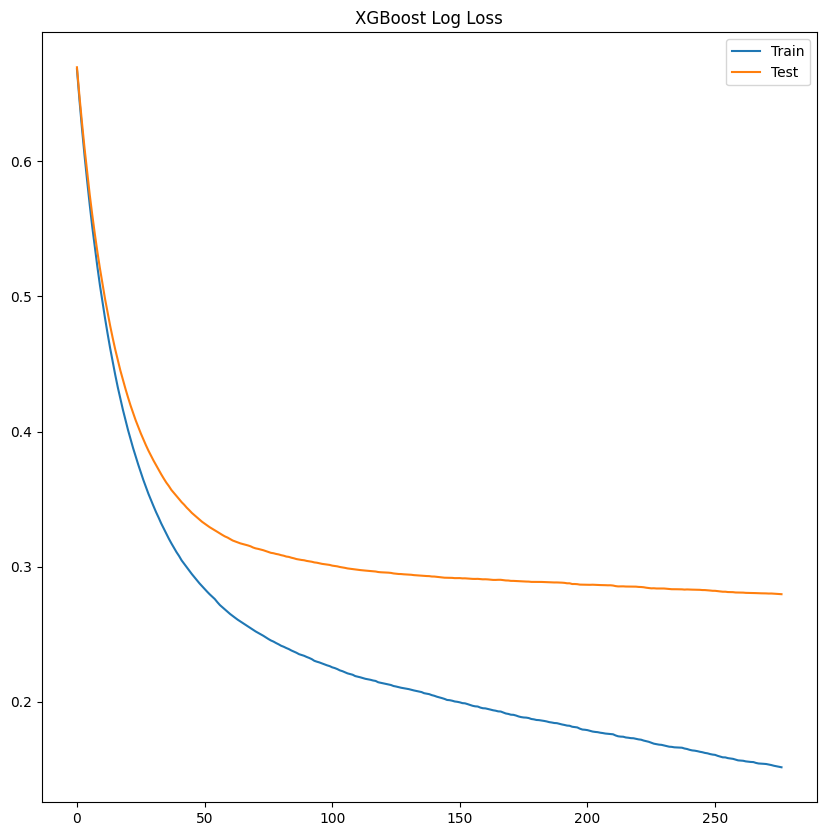

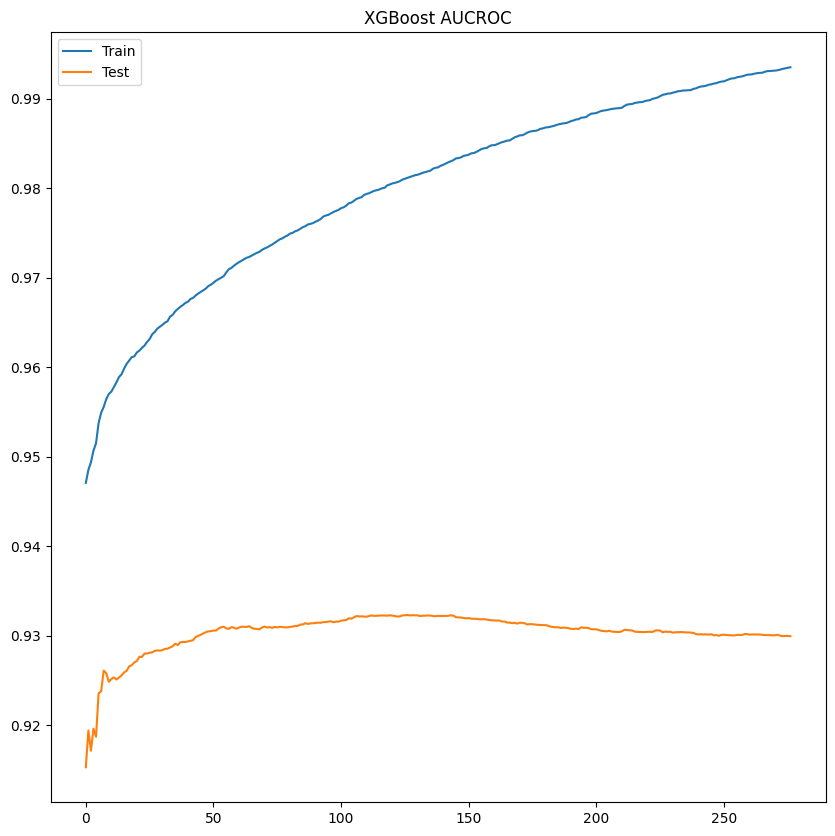

In [95]:
# make predictions for test data
y_pred = model.predict(select_X_test)
y_pred = [round(value) for value in y_pred]

y_pred_train = model.predict(select_X_train)
y_pred_train = [round(value) for value in y_pred_train]

# evaluate predictions
accuracy_test = accuracy_score(Y_test, y_pred)
print("Test Accuracy: %.2f%%" % (accuracy_test * 100.0))
accuracy_train = accuracy_score(Y_train, y_pred_train)
print("Train Accuracy: %.2f%%" % (accuracy_train * 100.0))
print("")

# confusion matrix 
cm = confusion_matrix(Y_test, y_pred)
cmtx = pd.DataFrame(cm, index=['actual:no', 'actual:yes'], columns=['pred:no', 'pred:yes'])
print("Confusion matrix:")
print(cmtx)
print("")

tn, fp, fn, tp = cm.ravel()
print(f'True Negatives: {tn}, False Positives: {fp}, False negatives: {fn}, True positives: {tp}')
print("")

eval_df = pd.DataFrame(precision_recall_fscore_support(Y_test, y_pred), 
index=["Precision", "Recall", "Fscore", "Support"], columns=["Class 0", "Class 1"])
print(eval_df)
print("")

# performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# plot log loss for train and test
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.title('XGBoost Log Loss')
plt.show()

# plot AUC for train and test
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.title('XGBoost AUCROC')
plt.show()

print('Test ROC AUC: %.3f' % results['validation_1']['auc'][-1])
print('Test logloss: %.3f' % results['validation_1']['logloss'][-1])